Copyright 2023 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Adversarial training


[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google-deepmind/optax/blob/main/examples/adversarial_training.ipynb)


The following code trains a convolutional neural network (CNN) to be robust
with respect to the projected gradient descent (PGD) method.

The Projected Gradient Descent Method (PGD) is a simple yet effective method to
generate adversarial images. At each iteration, it adds a small perturbation
in the direction of the sign of the gradient with respect to the input followed
by a projection onto the infinity ball. The gradient sign ensures this
perturbation locally maximizes the objective, while the projection ensures this
perturbation stays on the boundary of the infinity ball.

## References

  Goodfellow, Ian J., Jonathon Shlens, and Christian Szegedy. "Explaining
  and harnessing adversarial examples.", https://arxiv.org/abs/1412.6572

  Madry, Aleksander, et al. "Towards deep learning models resistant to
  adversarial attacks.", https://arxiv.org/abs/1706.06083

In [1]:
%pip install git+https://github.com/deepmind/optax.git

  Cloning https://github.com/deepmind/optax.git to /tmp/pip-req-build-f5x95enz
  Running command git clone --filter=blob:none --quiet https://github.com/deepmind/optax.git /tmp/pip-req-build-f5x95enz
  Resolved https://github.com/deepmind/optax.git to commit be7aa2b04411d6d32e8f250e0f7d23c9702d7278
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import datetime

import jax
from jax import numpy as jnp
from flax import linen as nn

import optax
from optax.losses import softmax_cross_entropy_with_integer_labels
from optax.tree_utils import tree_l2_norm

from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 22})

import tensorflow as tf
import tensorflow_datasets as tfds

# Hide any GPUs from TensorFlow. Otherwise TF might reserve memory and make
# it unavailable to JAX.
tf.config.experimental.set_visible_devices([], "GPU")

# Show on which platform JAX is running.
print("JAX running on", jax.devices()[0].platform.upper())

JAX running on GPU


In [3]:
# @markdown Total number of epochs to train for:
EPOCHS = 10  # @param{type:"integer"}
# @markdown Number of samples for each batch in the training set:
TRAIN_BATCH_SIZE = 128  # @param{type:"integer"}
# @markdown Number of samples for each batch in the test set:
TEST_BATCH_SIZE = 128  # @param{type:"integer"}
# @markdown Learning rate for the optimizer:
LEARNING_RATE = 0.001  # @param{type:"number"}
# @markdown The dataset to use.
DATASET = "mnist"  # @param{type:"string"}
# @markdown The amount of L2 regularization to use:
L2_REG = 0.0001  # @param{type:"number"}
# @markdown Adversarial perturbations lie within the infinity-ball of radius epsilon.
EPSILON = 0.01 # @param{type:"number"}

In [4]:
class CNN(nn.Module):
  """A simple CNN model."""
  num_classes: int

  @nn.compact
  def __call__(self, x):
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))  # flatten
    x = nn.Dense(features=256)(x)
    x = nn.relu(x)
    x = nn.Dense(features=self.num_classes)(x)
    return x

In [5]:
(train_loader, test_loader), mnist_info = tfds.load("mnist", split=["train", "test"], as_supervised=True, with_info=True)

train_loader_batched = train_loader.shuffle(10 * TRAIN_BATCH_SIZE, seed=0).batch(TRAIN_BATCH_SIZE, drop_remainder=True)
test_loader_batched = test_loader.batch(TEST_BATCH_SIZE, drop_remainder=True)

input_shape = (1,) + mnist_info.features["image"].shape
num_classes = mnist_info.features["label"].num_classes
iter_per_epoch_train = mnist_info.splits['train'].num_examples // TRAIN_BATCH_SIZE
iter_per_epoch_test = mnist_info.splits['test'].num_examples // TEST_BATCH_SIZE

In [6]:
net = CNN(num_classes)

@jax.jit
def accuracy(params, data):
  inputs, labels = data
  logits = net.apply({"params": params}, inputs)
  return jnp.mean(jnp.argmax(logits, axis=-1) == labels)


@jax.jit
def loss_fun(params, l2reg, data):
  """Compute the loss of the network."""
  inputs, labels = data
  x = inputs.astype(jnp.float32)
  logits = net.apply({"params": params}, x)
  sqnorm = tree_l2_norm(params, squared=True)
  loss_value = jnp.mean(softmax_cross_entropy_with_integer_labels(logits, labels))
  return loss_value + 0.5 * l2reg * sqnorm

@jax.jit
def pgd_attack(image, label, params, epsilon=0.1, maxiter=10):
  """PGD attack on the L-infinity ball with radius epsilon.

  Args:
    image: array-like, input data for the CNN
    label: integer, class label corresponding to image
    params: tree, parameters of the model to attack
    epsilon: float, radius of the L-infinity ball.
    maxiter: int, number of iterations of this algorithm.

  Returns:
    perturbed_image: Adversarial image on the boundary of the L-infinity ball
      of radius epsilon and centered at image.

  Notes:
    PGD attack is described in (Madry et al. 2017),
    https://arxiv.org/pdf/1706.06083.pdf
  """
  image_perturbation = jnp.zeros_like(image)
  def adversarial_loss(perturbation):
    return loss_fun(params, 0, (image + perturbation, label))

  grad_adversarial = jax.grad(adversarial_loss)
  for _ in range(maxiter):
    # compute gradient of the loss wrt to the image
    sign_grad = jnp.sign(grad_adversarial(image_perturbation))

    # heuristic step-size 2 eps / maxiter
    image_perturbation += (2 * epsilon / maxiter) * sign_grad
    # projection step onto the L-infinity ball centered at image
    image_perturbation = jnp.clip(image_perturbation, - epsilon, epsilon)

  # clip the image to ensure pixels are between 0 and 1
  return jnp.clip(image + image_perturbation, 0, 1)

In [7]:
def dataset_stats(params, data_loader, iter_per_epoch):
  """Computes accuracy on clean and adversarial images."""
  adversarial_accuracy = 0.
  clean_accuracy = 0.
  for batch in data_loader.as_numpy_iterator():
    images, labels = batch
    images = images.astype(jnp.float32) / 255
    clean_accuracy += jnp.mean(accuracy(params, (images, labels))) / iter_per_epoch
    adversarial_images = pgd_attack(images, labels, params, epsilon=EPSILON)
    adversarial_accuracy += jnp.mean(accuracy(params, (adversarial_images, labels))) / iter_per_epoch
  return {"adversarial accuracy": adversarial_accuracy, "accuracy": clean_accuracy}

@jax.jit
def train_step(params, opt_state, batch):
  images, labels = batch
  # convert images to float as attack requires to take gradients wrt to them
  images = images.astype(jnp.float32) / 255
  adversarial_images_train = pgd_attack(images, labels, params, epsilon=EPSILON)
  # train on adversarial images
  loss_grad_fun = jax.grad(loss_fun)
  grads = loss_grad_fun(params, L2_REG, (adversarial_images_train, labels))
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  return params, opt_state

In [8]:
# Initialize parameters.
key = jax.random.PRNGKey(0)
params = net.init(key, jnp.zeros(input_shape))["params"]

# Initialize the optimizer.
optimizer = optax.adam(LEARNING_RATE)
opt_state = optimizer.init(params)

start = datetime.datetime.now().replace(microsecond=0)

accuracy_train = []
accuracy_test = []
adversarial_accuracy_train = []
adversarial_accuracy_test = []
for epoch in range(EPOCHS):
  for batch in train_loader_batched.as_numpy_iterator():
    params, opt_state = train_step(params, opt_state, batch)

  # compute train set accuracy, both on clean and adversarial images
  train_stats = dataset_stats(params, train_loader_batched, iter_per_epoch_train)
  accuracy_train.append(train_stats["accuracy"])
  adversarial_accuracy_train.append(train_stats["adversarial accuracy"])

  # compute test set accuracy, both on clean and adversarial images
  test_stats = dataset_stats(params, test_loader_batched, iter_per_epoch_test)
  accuracy_test.append(test_stats["accuracy"])
  adversarial_accuracy_test.append(test_stats["adversarial accuracy"])

  time_elapsed = (datetime.datetime.now().replace(microsecond=0) - start)
  print(f"Epoch {epoch} out of {EPOCHS}")
  print(f"Accuracy on train set: {accuracy_train[-1]:.3f}")
  print(f"Accuracy on test set: {accuracy_test[-1]:.3f}")
  print(f"Adversarial accuracy on train set: {adversarial_accuracy_train[-1]:.3f}")
  print(f"Adversarial accuracy on test set: {adversarial_accuracy_test[-1]:.3f}")
  print(f"Time elapsed: {time_elapsed}\n")

Epoch 0 out of 10
Accuracy on train set: 0.982
Accuracy on test set: 0.981
Adversarial accuracy on train set: 0.979
Adversarial accuracy on test set: 0.978
Time elapsed: 0:00:28

Epoch 1 out of 10
Accuracy on train set: 0.989
Accuracy on test set: 0.986
Adversarial accuracy on train set: 0.987
Adversarial accuracy on test set: 0.984
Time elapsed: 0:00:42

Epoch 2 out of 10
Accuracy on train set: 0.991
Accuracy on test set: 0.988
Adversarial accuracy on train set: 0.988
Adversarial accuracy on test set: 0.985
Time elapsed: 0:01:00

Epoch 3 out of 10
Accuracy on train set: 0.992
Accuracy on test set: 0.989
Adversarial accuracy on train set: 0.990
Adversarial accuracy on test set: 0.987
Time elapsed: 0:01:14

Epoch 4 out of 10
Accuracy on train set: 0.992
Accuracy on test set: 0.988
Adversarial accuracy on train set: 0.990
Adversarial accuracy on test set: 0.985
Time elapsed: 0:01:32

Epoch 5 out of 10
Accuracy on train set: 0.995
Accuracy on test set: 0.991
Adversarial accuracy on train 

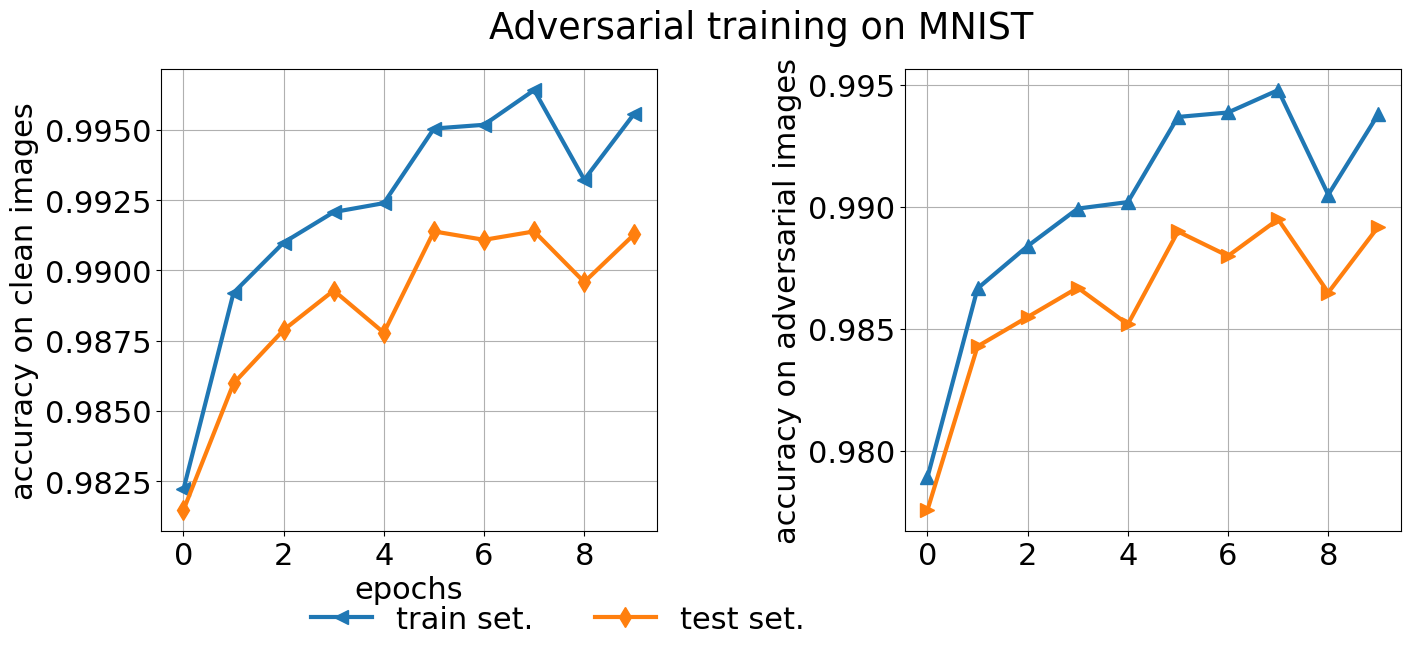

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

plt.suptitle("Adversarial training on " + f"{DATASET}".upper())
axes[0].plot(accuracy_train, lw=3, label="train set." , marker='<', markersize=10)
axes[0].plot(accuracy_test, lw=3, label="test set.", marker='d', markersize=10)
axes[0].grid()
axes[0].set_ylabel('accuracy on clean images')

axes[1].plot(
    adversarial_accuracy_train,
    lw=3,
    label="adversarial accuracy on train set.", marker='^', markersize=10)
axes[1].plot(
    adversarial_accuracy_test,
    lw=3,
    label="adversarial accuracy on test set.", marker='>', markersize=10)
axes[1].grid()
axes[0].legend(frameon=False, ncol=2, loc='upper center', bbox_to_anchor=(0.8, -0.1))
axes[0].set_xlabel('epochs')
axes[1].set_ylabel('accuracy on adversarial images')
plt.subplots_adjust( wspace=0.5 )


plt.show()

Find a test set image that is correctly classified but not its adversarial perturbation

In [10]:
def find_adversarial_imgs():
  for batch in test_loader_batched.as_numpy_iterator():
    images, labels = batch
    images = images.astype(jnp.float32) / 255
    logits = net.apply({"params": params}, images)
    labels_clean = jnp.argmax(logits, axis=-1)

    adversarial_images = pgd_attack(
      images, labels, params, epsilon=EPSILON)
    labels_adversarial = jnp.argmax(net.apply({"params": params}, adversarial_images), axis=-1)
    idx_misclassified = jnp.where(labels_clean != labels_adversarial)[0]
    if len(idx_misclassified) == 0:
      continue
    else:
      for i in idx_misclassified:
        img_clean = images[i]
        prediction_clean = labels_clean[i]
        if prediction_clean != labels[i]:
          # the clean image predicts the wrong label, skip
          continue
        img_adversarial = adversarial_images[i]
        prediction_adversarial = labels_adversarial[i]
        # we found our image
        return img_clean, prediction_clean, img_adversarial, prediction_adversarial

  raise ValueError("No mismatch between clean and adversarial prediction found")

img_clean, prediction_clean, img_adversarial, prediction_adversarial = \
  find_adversarial_imgs()

<ipython-input-12-a38a48a58a76>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  axes[0].imshow(img_clean, cmap=plt.cm.get_cmap('Greys'), vmax=1, vmin=0)
<ipython-input-12-a38a48a58a76>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  axes[1].imshow(img_adversarial, cmap=plt.cm.get_cmap('Greys'), vmax=1, vmin=0)
<ipython-input-12-a38a48a58a76>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  axes[2].imshow(jnp.abs(img_clean - img_adversarial) / EPSILON, cmap=plt.cm.get_cmap('G

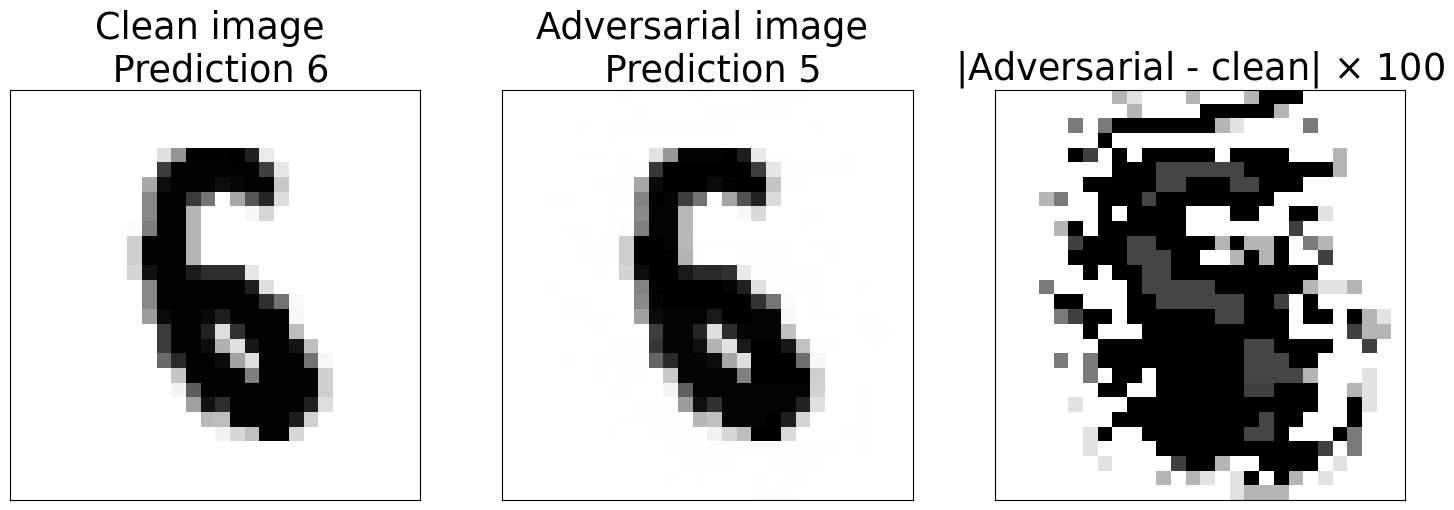

In [11]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(6*3, 6))

axes[0].set_title('Clean image \n Prediction %s' % int(prediction_clean))
axes[0].imshow(img_clean, cmap=plt.cm.get_cmap('Greys'), vmax=1, vmin=0)
axes[1].set_title('Adversarial image \n Prediction %s' % prediction_adversarial)
axes[1].imshow(img_adversarial, cmap=plt.cm.get_cmap('Greys'), vmax=1, vmin=0)
axes[2].set_title(r'|Adversarial - clean| $\times$ %.0f' % (1/EPSILON))
axes[2].imshow(jnp.abs(img_clean - img_adversarial) / EPSILON, cmap=plt.cm.get_cmap('Greys'), vmax=1, vmin=0)
for i in range(3):
    axes[i].set_xticks(())
    axes[i].set_yticks(())
plt.show()